# Diabetes Risk Analysis (Week 2)
# Name-Pranay Nigam (AIML)

This notebook performs an end-to-end Exploratory Data Analysis (EDA) and baseline modeling on the PIMA Indians Diabetes dataset.

Objectives:
- Understand the dataset and feature distributions
- Handle missing/invalid values (e.g., zeros in medical measurements)
- Visualize correlations and class balance
- Build baseline models (Logistic Regression, Random Forest)
- Evaluate with accuracy, precision, recall, F1, ROC-AUC

Data Source: Public copy of PIMA Diabetes dataset hosted on GitHub (Plotly datasets mirror).

In [5]:
# Show dataset rows and columns
n_rows, n_cols = df.shape
print(f"Rows: {n_rows}, Columns: {n_cols}")

Rows: 768, Columns: 9


In [2]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve, confusion_matrix, classification_report)
sns.set(style="whitegrid", context="notebook")
pd.set_option('display.max_columns', None)

## 1) Load Data
We'll load the dataset from a raw CSV URL. If the URL is unavailable, you can place a local `diabetes.csv` in the same folder and set `DATA_PATH` accordingly.

In [4]:
# Download/Load dataset
DATA_URL = 'https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv'
local_path = 'diabetes.csv'

try:
    df = pd.read_csv(DATA_URL)
except Exception as e:
    print('Falling back to local file due to:', e)
    df = pd.read_csv(local_path)

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


## 2) Data Quality & Cleaning
In this dataset, some medical measurements cannot be zero. We'll treat zeros in these columns as missing and impute with the median.

Columns to fix: `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin`, `BMI`.

In [6]:
cols_with_invalid_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
# Count zeros before
zero_counts = {c: int((df[c] == 0).sum()) for c in cols_with_invalid_zero}
zero_counts

{'Glucose': 5,
 'BloodPressure': 35,
 'SkinThickness': 227,
 'Insulin': 374,
 'BMI': 11}

In [8]:
# Replace zeros with NaN for the specified columns
df_clean = df.copy()
for c in cols_with_invalid_zero:
    df_clean.loc[df_clean[c] == 0, c] = np.nan

# Impute with median
for c in cols_with_invalid_zero:
    median_val = df_clean[c].median()
    df_clean[c].fillna(median_val, inplace=True)

df_clean[cols_with_invalid_zero].describe().T

C:\Users\Aayush\AppData\Local\Temp\ipykernel_13880\599849250.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean[c].fillna(median_val, inplace=True)
C:\Users\Aayush\AppData\Local\Temp\ipykernel_13880\599849250.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example

,count,mean,std,min,25%,50%,75%,max
Glucose,768.0,121.656250,30.438286,44.0,99.75,117.0,140.25,199.0
BloodPressure,768.0,72.386719,12.096642,24.0,64.00,72.0,80.00,122.0
SkinThickness,768.0,29.108073,8.791221,7.0,25.00,29.0,32.00,99.0
Insulin,768.0,140.671875,86.383060,14.0,121.50,125.0,127.25,846.0
BMI,768.0,32.455208,6.875177,18.2,27.50,32.3,36.60,67.1


## 3) Exploratory Data Analysis
We'll visualize distributions, class balance, correlations, and relationships.

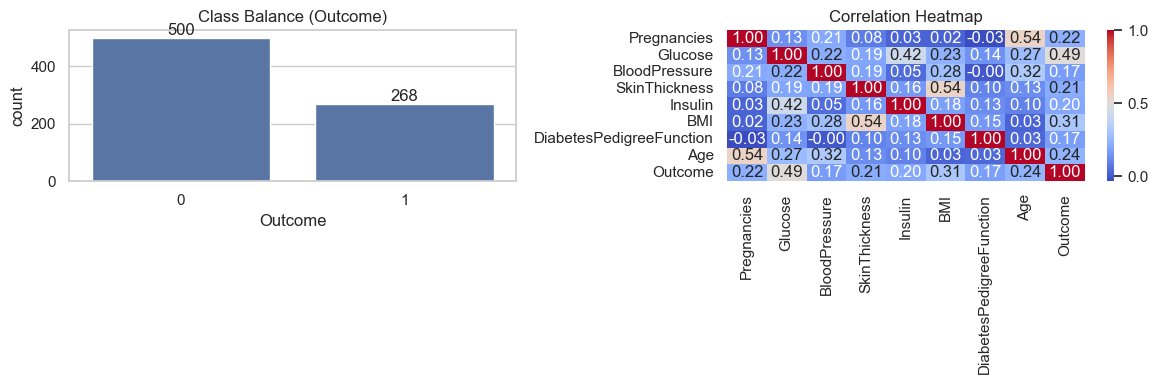

In [9]:
# Target distribution
fig, ax = plt.subplots(1,2, figsize=(12,4))
sns.countplot(data=df_clean, x='Outcome', ax=ax[0])
ax[0].set_title('Class Balance (Outcome)')
ax[0].bar_label(ax[0].containers[0])

# Correlation heatmap
corr = df_clean.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', ax=ax[1])
ax[1].set_title('Correlation Heatmap')
plt.tight_layout()
plt.show()

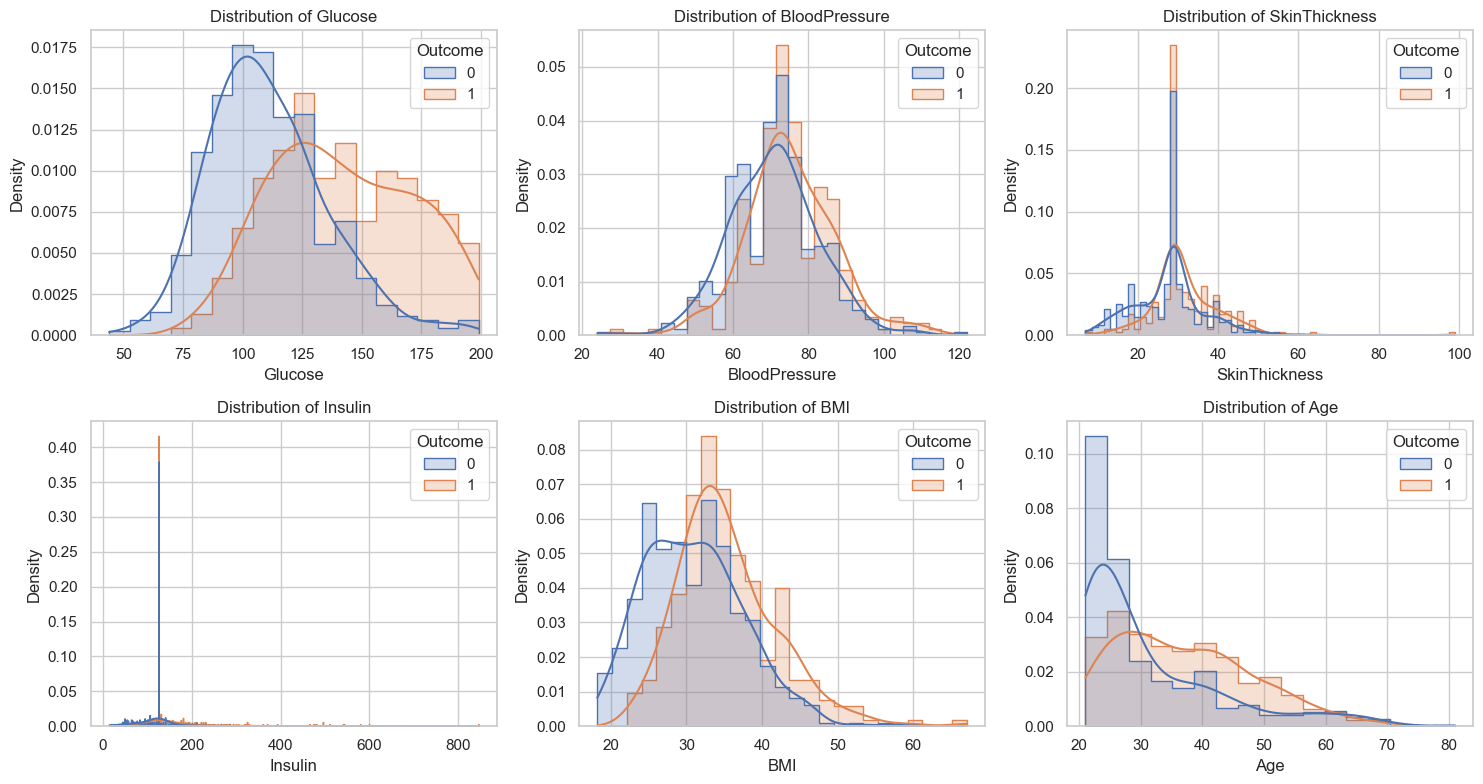

In [10]:
# Distributions for key features
features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'Age']
fig, axes = plt.subplots(2, 3, figsize=(15,8))
axes = axes.ravel()
for i, f in enumerate(features):
    sns.histplot(data=df_clean, x=f, hue='Outcome', kde=True, ax=axes[i], element='step', stat='density', common_norm=False)
    axes[i].set_title(f'Distribution of {f}')
plt.tight_layout()
plt.show()

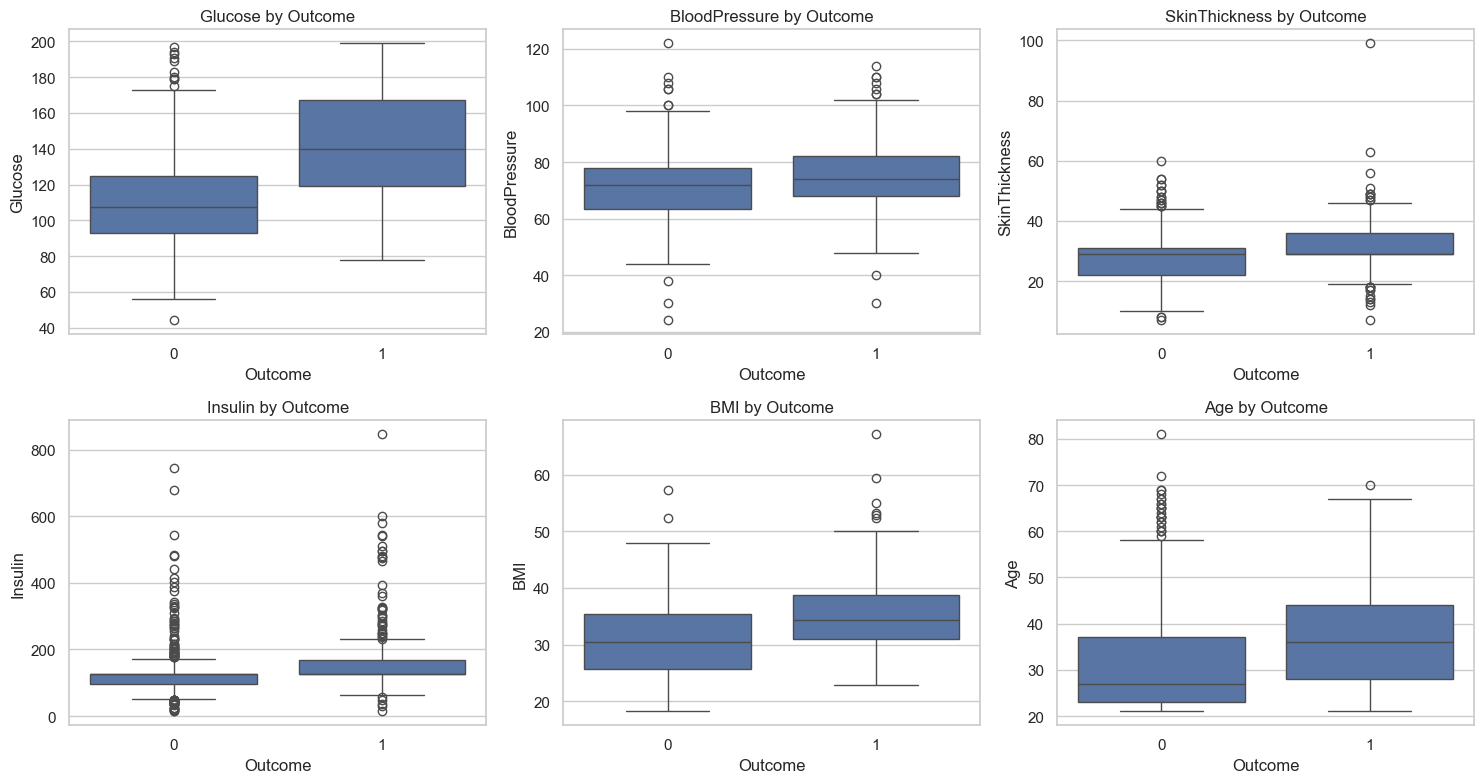

In [11]:
# Boxplots to check outliers by class
fig, axes = plt.subplots(2, 3, figsize=(15,8))
axes = axes.ravel()
for i, f in enumerate(features):
    sns.boxplot(data=df_clean, x='Outcome', y=f, ax=axes[i])
    axes[i].set_title(f'{f} by Outcome')
plt.tight_layout()
plt.show()

## 4) Train/Test Split and Scaling
We'll create train/test sets. For models that benefit from scaling (Logistic Regression), we'll scale features with `StandardScaler`.

In [13]:
X = df_clean.drop('Outcome', axis=1)
y = df_clean['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 5) Baseline Models
We train Logistic Regression and Random Forest.

In [14]:
# Logistic Regression (with scaled features)
log_reg = LogisticRegression(max_iter=200, random_state=42)
log_reg.fit(X_train_scaled, y_train)
y_pred_lr = log_reg.predict(X_test_scaled)
y_prob_lr = log_reg.predict_proba(X_test_scaled)[:,1]

# Random Forest (tree-based models don't need feature scaling)
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:,1]

In [21]:
def evaluate_model(y_true, y_pred, y_prob, model_name="Model"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    roc = roc_auc_score(y_true, y_prob)
    print(f'=== {model_name} ===')
    print(f'Accuracy : {acc:.3f}')
    print(f'Precision: {prec:.3f}')
    print(f'Recall   : {rec:.3f}')
    print(f'F1-score : {f1:.3f}')
    print(f'ROC-AUC  : {roc:.3f}')
    print('Confusion Matrix:')
    print(confusion_matrix(y_true, y_pred))
    print('Classification Report:')
    print(classification_report(y_true, y_pred, zero_division=0))

evaluate_model(y_test, y_pred_lr, y_prob_lr, 'Logistic Regression')
evaluate_model(y_test, y_pred_rf, y_prob_rf, 'Random Forest')

=== Logistic Regression ===
Accuracy : 0.708
Precision: 0.600
Recall   : 0.500
F1-score : 0.545
ROC-AUC  : 0.813
Confusion Matrix:
[[82 18]
 [27 27]]
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.82      0.78       100
           1       0.60      0.50      0.55        54

    accuracy                           0.71       154
   macro avg       0.68      0.66      0.67       154
weighted avg       0.70      0.71      0.70       154

=== Random Forest ===
Accuracy : 0.734
Precision: 0.644
Recall   : 0.537
F1-score : 0.586
ROC-AUC  : 0.816
Confusion Matrix:
[[84 16]
 [25 29]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.84      0.80       100
           1       0.64      0.54      0.59        54

    accuracy                           0.73       154
   macro avg       0.71      0.69      0.69       154
weighted avg       0.73      0.73      0.73       154



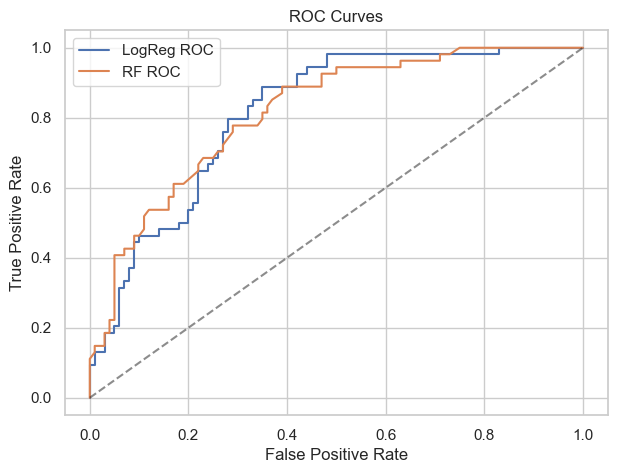

In [23]:
# ROC Curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(7,5))
plt.plot(fpr_lr, tpr_lr, label='LogReg ROC')
plt.plot(fpr_rf, tpr_rf, label='RF ROC')
plt.plot([0,1], [0,1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

## 6) Feature Importance (Random Forest)
We inspect feature importances from the Random Forest model.

C:\Users\Aayush\AppData\Local\Temp\ipykernel_13880\815528850.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette='viridis')


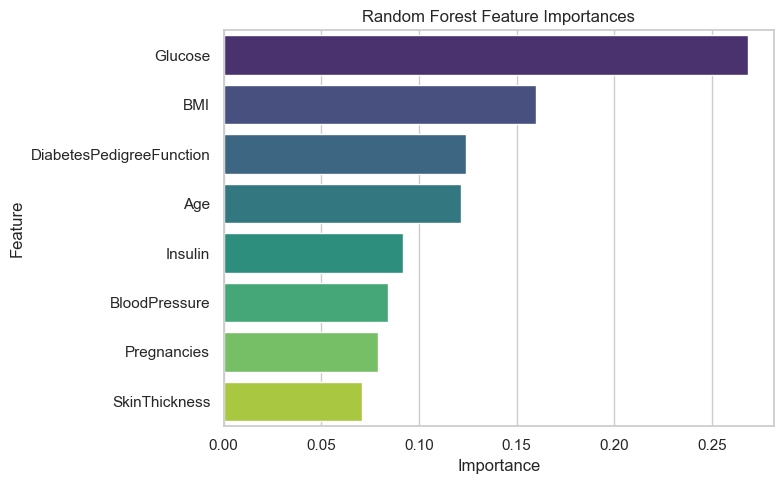

Glucose                     0.268206
BMI                         0.160049
DiabetesPedigreeFunction    0.124236
Age                         0.121695
Insulin                     0.091632
BloodPressure               0.084178
Pregnancies                 0.078972
SkinThickness               0.071033
dtype: float64

In [22]:
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=importances.values, y=importances.index, palette='viridis')
plt.title('Random Forest Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
importances

## 7. Conclusion

- The PIMA Diabetes dataset contains 768 rows and 9 features. After treating biologically-impossible zeros in `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin`, and `BMI` as missing and imputing with medians, the data is ready for analysis.
- EDA shows stronger associations with `Outcome` for `Glucose`, `BMI`, `Age`, and `Pregnancies`. The target is skewed toward non-diabetic cases, so prioritize recall and ROC-AUC alongside accuracy.
- Baseline models (Logistic Regression with scaling and Random Forest without scaling) achieve reasonable performance. Choose the model with higher ROC-AUC and better precision–recall trade-off for `Outcome = 1`. Carefully inspect false negatives in the confusion matrix, as missing positive cases is costly in risk screening.

### Practical Takeaways
- Elevated glucose and higher BMI are key risk indicators; age and pregnancy count add predictive signal.
- The baseline models form a solid starting point; sensitivity (recall) can be improved with tuning.

### Recommended Next Steps
- Hyperparameter tuning with cross-validation (GridSearchCV/RandomizedSearchCV).
- Address class imbalance using `class_weight='balanced'` or SMOTE; review PR curves.
- Decision threshold tuning to optimize for recall or F1 based on project goals.
- Probability calibration (e.g., `CalibratedClassifierCV`) for better risk scoring.
- Interpretability via SHAP or permutation importance to quantify feature impacts.